In [1]:
#
# This is a sample Notebook to demonstrate how to read "MNIST Dataset"
#
import numpy as np # linear algebra
import struct
from array import array
from os.path  import join

#
# MNIST Data Loader Class
#
class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
    
    def read_images_labels(self, images_filepath, labels_filepath):        
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())        
        
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())        
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img            
        
        return images, labels
            
    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test)

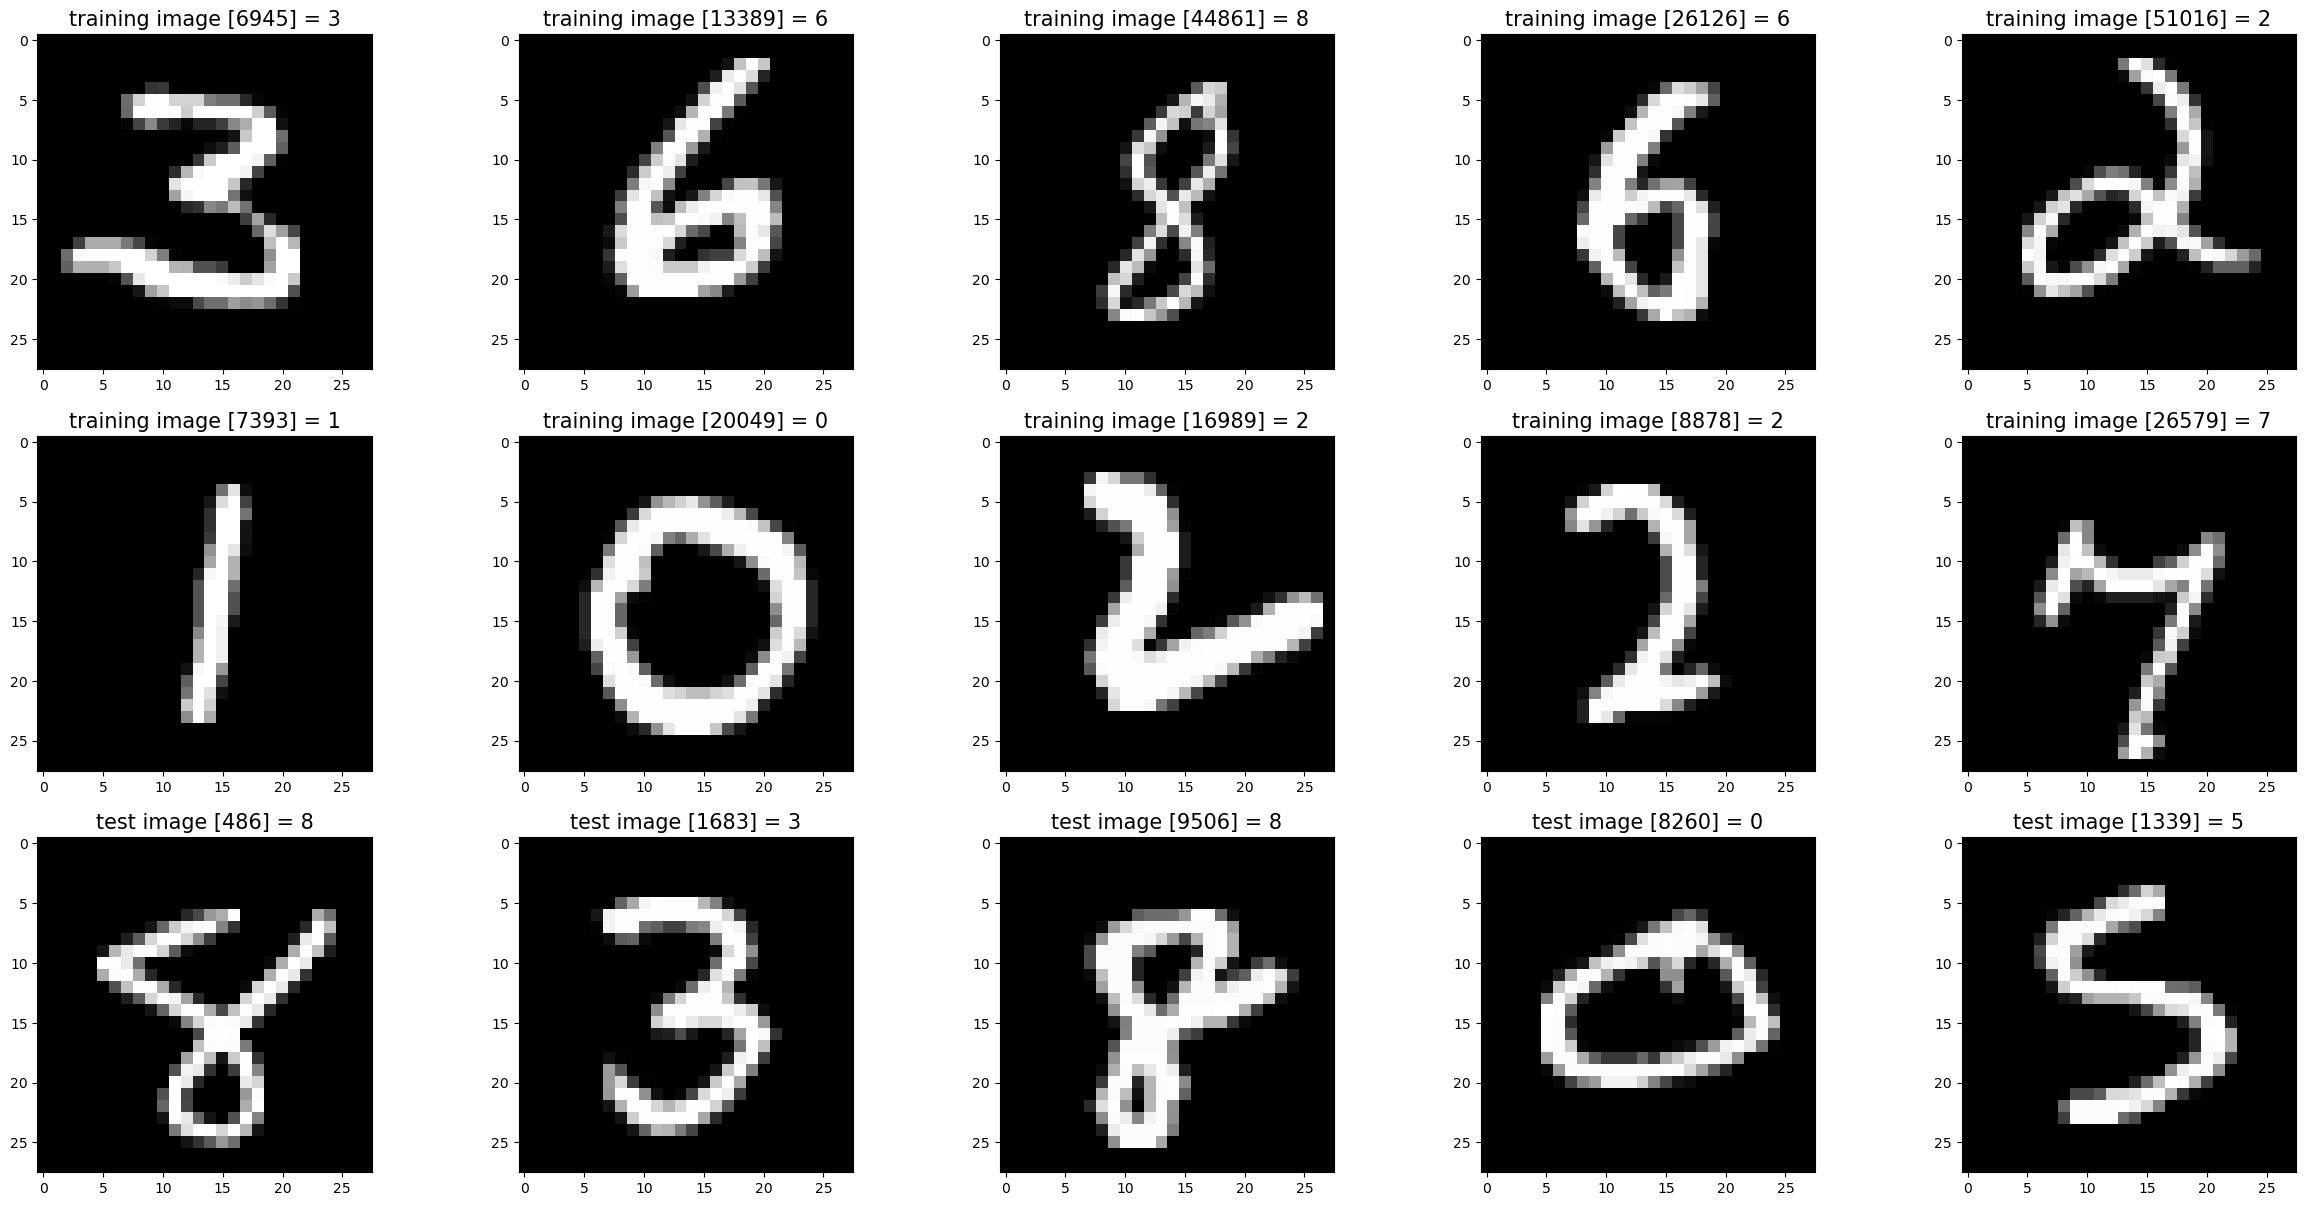

In [4]:
#
# Verify Reading Dataset via MnistDataloader class
#
%matplotlib inline
import random
import matplotlib.pyplot as plt

#
# Set file paths based on added MNIST Datasets
#
input_path = '.\\'
training_images_filepath = join(input_path, 'train-images-idx3-ubyte/train-images-idx3-ubyte')
training_labels_filepath = join(input_path, 'train-labels-idx1-ubyte/train-labels-idx1-ubyte')
test_images_filepath = join(input_path, 't10k-images-idx3-ubyte/t10k-images-idx3-ubyte')
test_labels_filepath = join(input_path, 't10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte')

#
# Helper function to show a list of images with their relating titles
#
def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(30,20))
    index = 1    
    for x in zip(images, title_texts):        
        image = x[0]        
        title_text = x[1]
        plt.subplot(rows, cols, index)        
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);        
        index += 1

#
# Load MINST dataset
#
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()

#
# Show some random training and test images 
#
images_2_show = []
titles_2_show = []
for i in range(0, 10):
    r = random.randint(1, 60000)
    images_2_show.append(x_train[r])
    titles_2_show.append('training image [' + str(r) + '] = ' + str(y_train[r]))    

for i in range(0, 5):
    r = random.randint(1, 10000)
    images_2_show.append(x_test[r])        
    titles_2_show.append('test image [' + str(r) + '] = ' + str(y_test[r]))    

show_images(images_2_show, titles_2_show)

In [77]:
import numpy as np

class MLP:
    def __init__(self, layer_sizes, learning_rate=0.01):
        """
        layer_sizes örn: [2, 8, 6, 1]
        """
        self.layer_sizes = layer_sizes
        self.lr = learning_rate
        self.L = len(layer_sizes) - 1  # weight layer sayısı
        
        self.weights = []
        self.biases = []
        
        # He initialization (ReLU için uygun)
        for i in range(self.L):
            w = np.random.randn(layer_sizes[i], layer_sizes[i+1]) * np.sqrt(2 / layer_sizes[i])
            b = np.zeros((1, layer_sizes[i+1]))
            self.weights.append(w)
            self.biases.append(b)

    # ------------------
    # Aktivasyonlar
    # ------------------

    def relu(self, z):
        return np.maximum(0, z)

    def relu_derivative(self, z):
        return (z > 0).astype(float)

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def sigmoid_derivative(self, a):
        return a * (1 - a)
    
    def softmax(self, z):
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)
    
    def softmax_derivative(self, a):
        return a * (1 - a)
    
    

    # ------------------
    # Forward Pass
    # ------------------

    def forward(self, X):
        self.activations = [X]
        self.z_values = []
        
        A = X
        
        for i in range(self.L):
            Z = A @ self.weights[i] + self.biases[i]
            self.z_values.append(Z)
            
            if i == self.L - 1:
                A = self.sigmoid(Z)  # output layer
            else:
                A = self.relu(Z)
                
            self.activations.append(A)
            
        return A

    # ------------------
    # Loss
    # ------------------

    def compute_loss(self, y_true, y_pred):
        return np.mean((y_true - y_pred) ** 2)

    # ------------------
    # Backpropagation
    # ------------------

    def backward(self, y_true):
        m = y_true.shape[0]
        
        dA = -(y_true - self.activations[-1])
        
        for i in reversed(range(self.L)):
            A_prev = self.activations[i]
            Z = self.z_values[i]
            
            if i == self.L - 1:
                dZ = dA * self.sigmoid_derivative(self.activations[-1])
            else:
                dZ = dA * self.relu_derivative(Z)
            
            dW = (A_prev.T @ dZ) / m
            db = np.sum(dZ, axis=0, keepdims=True) / m
            
            dA = dZ @ self.weights[i].T
            
            self.weights[i] -= self.lr * dW
            self.biases[i] -= self.lr * db

    # ------------------
    # Training
    # ------------------

    def train(self, X, y, epochs=5000, verbose=True):
        for epoch in range(epochs):
            y_pred = self.forward(X)
            loss = self.compute_loss(y, y_pred)
            self.backward(y)
            
            if verbose and epoch % 500 == 0:
                print(f"Epoch {epoch}, Loss: {loss:.6f}")

    def predict(self, X):
        y_pred = self.forward(X)
        return (y_pred).astype(float)

In [78]:
# 2 gizli katmanlı ağ
model = MLP([784, 128, 64, 10], learning_rate=0.01)

In [45]:
x_train = np.array(x_train).reshape(-1, 28*28)
x_train.shape

(60000, 784)

In [79]:
y_train = np.array(y_train).reshape(-1, 1)
y_train = y_train.flatten()          # (60000,)
y_onehot = np.eye(10)[y_train]       # (60000, 10)

In [80]:
model.train(x_train, y_onehot, epochs=1000)

Epoch 0, Loss: 0.449317


C:\Users\myilm\AppData\Local\Temp\ipykernel_30108\1589256961.py:33: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


Epoch 500, Loss: 0.085656


In [81]:
x_test = np.array(x_test).reshape(-1, 28*28)
y_test = np.array(y_test).reshape(-1, 1)
y_test = y_test.flatten()            # (10000,)
y_test_onehot = np.eye(10)[y_test] # (10000, 10)
y_pred = model.predict(x_test)
y_pred_labels = np.argmax(y_pred, axis=1)
accuracy = np.mean(y_pred_labels == y_test)
print(f"Test Accuracy: {accuracy:.4f}")


Test Accuracy: 0.2580


C:\Users\myilm\AppData\Local\Temp\ipykernel_30108\1589256961.py:33: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


In [83]:
print(y_test[0:30])
print(y_pred_labels[0:30])


[7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4 9 6 6 5 4 0 7 4 0 1]
[7 2 1 8 4 1 4 7 8 7 8 1 7 4 7 4 4 7 7 4 7 2 7 4 4 2 7 4 2 2]
